In [ ]:
!git clone "https://github.com/kk-digital/kcg-ml-sd1p4.git"
%cd kcg-ml-sd1p4

In [ ]:
!pip install -r requirements.txt

In [ ]:
%cd kcg-ml-sd1p4

In [ ]:
!python3 ./download_models.py

In [ ]:
!python3 ./process_models.py

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


INFO: NumExpr defaulting to 2 threads.


INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmphh0d5yz4


INFO: Created a temporary directory at /tmp/tmphh0d5yz4


INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmphh0d5yz4/_remote_module_non_scriptable.py


INFO: Writing /tmp/tmphh0d5yz4/_remote_module_non_scriptable.py


Loading tokenizer and transformer...[DONE]	4,341.29ms
Loading tokenizer and transformer...[DONE]	1,263.21ms
Before quantization: Min=-28.09117889404297, Max=33.06320571899414, Mean=-0.11118213087320328
After quantization: Min=-28.5, Max=33.0, Mean=-0.3606009781360626
Sample...[DONE]	6,692.27ms
Before quantization: Min=-28.09117889404297, Max=33.06320571899414, Mean=-0.11118213087320328
After quantization: Min=-28.25, Max=33.0, Mean=-0.23625625669956207
Sample...[DONE]	5,534.62ms
Before quantization: Min=-28.09117889404297, Max=33.06320571899414, Mean=-0.11118213087320328
After quantization: Min=-28.125, Max=33.0, Mean=-0.17388731241226196
Sample...[DONE]	5,581.67ms
Before quantization: Min=-28.09117889404297, Max=33.06320571899414, Mean=-0.11118213087320328
After quantization: Min=-28.125, Max=33.0625, Mean=-0.14232447743415833
Sample...[DONE]	5,641.90ms
Before quantization: Min=-28.09117889404297, Max=33.06320571899414, Mean=-0.11118213087320328
After quantization: Min=-28.09375, Max=

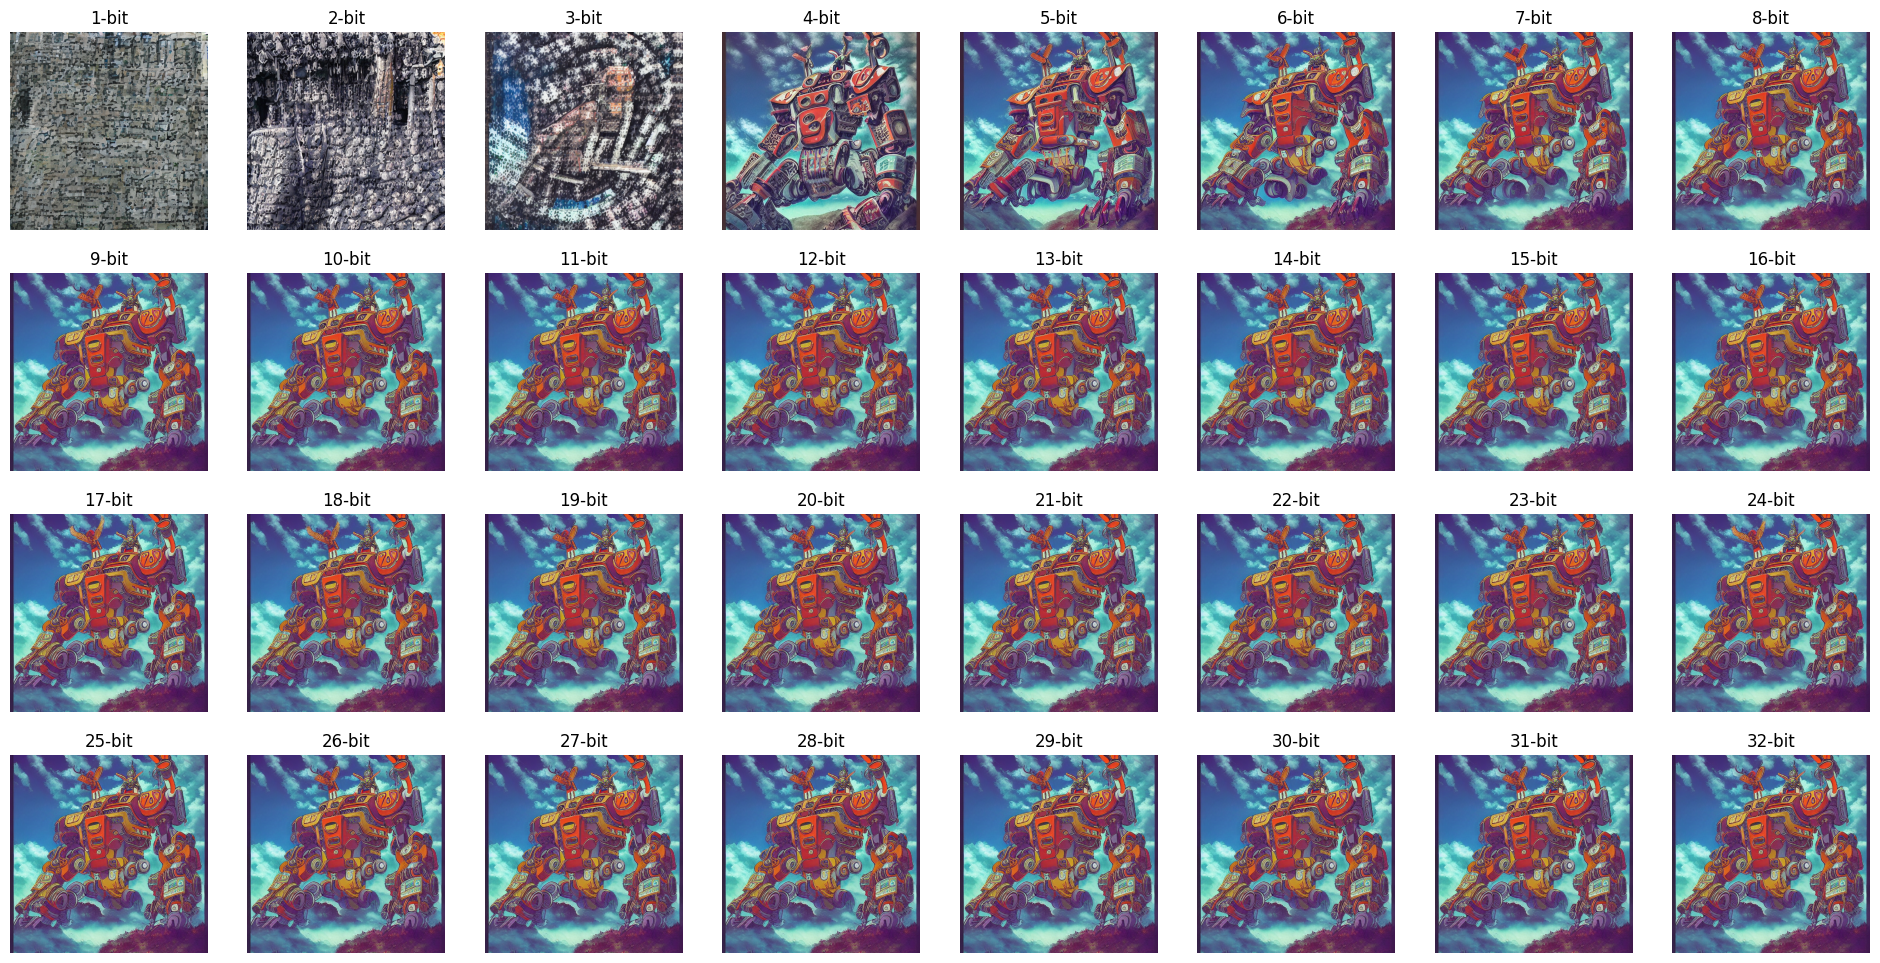

In [4]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from configs.model_config import ModelPathConfig
from stable_diffusion import StableDiffusion, SDconfigs
from stable_diffusion.utils_backend import get_device
from stable_diffusion.utils_image import to_pil
import ga
import math


# Initialize configurations
N_STEPS = 20
CFG_STRENGTH = 9

DEVICE = get_device()
config = ModelPathConfig()

# Load Stable Diffusion model
sd = StableDiffusion(device=DEVICE, n_steps=N_STEPS)
sd.quick_initialize().load_autoencoder(config.get_model(SDconfigs.VAE)).load_decoder(config.get_model(SDconfigs.VAE_DECODER))
sd.model.load_unet(config.get_model(SDconfigs.UNET))


def prompt_embedding_vectors(sd, prompt_array):
    embedded_prompts = ga.clip_text_get_prompt_embedding(config, prompts=prompt_array)
    embedded_prompts.to("cpu")
    return embedded_prompts

# Get null prompt and generate prompts
NULL_PROMPT = prompt_embedding_vectors(sd, [""])[0]
prompt_phrase_length = 10
prompts_count = 2
prompts_array = ga.generate_prompts(prompts_count, prompt_phrase_length)

# Get prompt string array
prompts_str_array = [prompt.get_positive_prompt_str() for prompt in prompts_array]

# Get embeddings and move to CPU
embedded_prompts = prompt_embedding_vectors(sd, prompt_array=prompts_str_array)
embedded_prompts_cpu = embedded_prompts.to("cpu").detach().numpy()
del embedded_prompts
torch.cuda.empty_cache()


def alternate_quantize(input_array, bits):
    level = bits
    bit_level = math.pow(0.5, level)

    def round_element(x):
        x_double = np.float64(x)  # Explicitly cast to double-precision float
        x_rem = x_double % bit_level
        result = x_double - x_rem
        return np.float32(result)  # Cast to single-precision float when done

    rounded_data = np.vectorize(round_element)(input_array)
    return rounded_data.astype(np.float32)  # Make sure the entire array is single-precision



# Initialize output directories and Matplotlib
fig, axs = plt.subplots(4, 8, figsize=(24, 12))  # Subplots for 1 to 32 bits

def generate_image(embedding, bits, ax):
    print(f"Before quantization: Min={np.min(embedding)}, Max={np.max(embedding)}, Mean={np.mean(embedding)}")
    embedding_quantized = alternate_quantize(embedding, bits)  # Using alternate_quantize function
    print(f"After quantization: Min={np.min(embedding_quantized)}, Max={np.max(embedding_quantized)}, Mean={np.mean(embedding_quantized)}")
    latent = sd.generate_images_latent_from_embeddings(
        seed=123,
        embedded_prompt=torch.tensor(embedding_quantized, dtype=torch.float32, device=DEVICE),
        null_prompt=NULL_PROMPT,
        uncond_scale=CFG_STRENGTH
    )
    image = sd.get_image_from_latent(latent)
    pil_image = to_pil(image[0])
    filename = os.path.join('output', f'{bits}bit', f'{bits}bit.png')
    pil_image.save(filename)
    ax.imshow(np.array(pil_image))
    ax.set_title(f'{bits}-bit')
    del latent, image
    torch.cuda.empty_cache()

for idx, bits in enumerate(range(1, 33)):  # From 1 to 32 bits
    row, col = divmod(idx, 8)
    os.makedirs(os.path.join('output', f'{bits}bit'), exist_ok=True)
    generate_image(embedded_prompts_cpu[0], bits, axs[row, col])

# Show the grid
for ax in axs.ravel():
    ax.axis('off')
plt.show()
